In [1]:
# Basic
from pathlib import Path
import pickle as pk
import os
import re
from typing import Tuple, Callable
from collections import Counter

# External
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow
# from tensorflow import keras
# from keras.models import load_model

# CASCID
from cascid.configs.config import DATA_DIR
from cascid.datasets.isic.database import get_train_test_images_hairless as get_isic_hairless, get_train_test_images_raw as get_isic_raw, get_train_test_images_hairless_quantized as get_isic_hq
from cascid.datasets.pad_ufes.database import get_train_test_images_hairless as get_pad_ufes_hairless, get_train_test_images_raw as get_pad_ufes_raw, get_train_test_images_hairless_quantized as get_pad_ufes_hq

# Constants
EXPERIMENT_DIR = DATA_DIR / 'experiments_strongaug'

2022-11-25 11:52:40.999901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 11:52:41.221231: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-25 11:52:41.901526: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-11-25 11:52:41.901603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
from cascid.datasets.pad_ufes.images import get_hairless_image, get_raw_image, get_hq_image, remove_hair, remove_hair_and_quantize
from cascid.datasets.pad_ufes.database import get_df
df = get_df()
imlist = df['img_id'].to_list()
remove_hair(imlist)
remove_hair_and_quantize(imlist)


Beginning transformations, this may take a while...
Finished transformations after 0h00min0.75s
Beginning transformations, this may take a while...
Finished transformations after 0h00min0.52s


In [3]:
def get_train_ratio_cancer(func: Callable) -> Tuple[float, float]:
    _, _, y_train, _ = func()
    cnt = Counter(y_train.flatten().tolist())
    s, h = 0., 0.
    for i, e in cnt.items():
        if i in ["BCC", "SCC", "MEL"]:
            h += e
        s += e
    return h/s

isic_raw_ratio = get_train_ratio_cancer(get_isic_raw)
isic_hairless_ratio = get_train_ratio_cancer(get_isic_hairless)
isic_hairless_hq_ratio = get_train_ratio_cancer(get_isic_hq)
pad_ufes_raw_ratio = get_train_ratio_cancer(get_pad_ufes_raw)
pad_ufes_hairless_ratio = get_train_ratio_cancer(get_pad_ufes_hairless)
pad_ufes_hairless_hq_ratio = get_train_ratio_cancer(get_pad_ufes_hq)

In [4]:
models = dict()
for d in ["final_isic" , "final_pad_ufes"]:
    for mod in ['resnet34', 'resnet18']:
        for style in ['aug_hairless', 'noaug_hairless', 'noaug_raw', 'aug_raw', 'aug_hq', 'noaug_hq']:
            path = EXPERIMENT_DIR / d / mod / style
            key = "{}_{}_{}".format(d , mod , style)
            # models[key] = load_model(path)
            try:
                with open(path / "history.pkl", "rb") as f:
                    models[key+"_history"] = pk.load(f)
            except OSError:
                continue

In [5]:
models_fixed = dict()
for k,v in models.items():
    models_fixed[k] = dict()
    for metric, history in v.items():
        if metric not in ["loss", "acc", "auc", "val_loss", "val_acc", "val_auc"]:
            fixed_metric = re.sub('_[0-9]', '', metric) # Remove _number from end of name
            fixed_metric = re.sub('[0-9]', '', fixed_metric) # Remove number from end of name
            models_fixed[k][fixed_metric] = history
        else:
            models_fixed[k][metric] = history

/tmp/ipykernel_186123/1118780864.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(9,4))


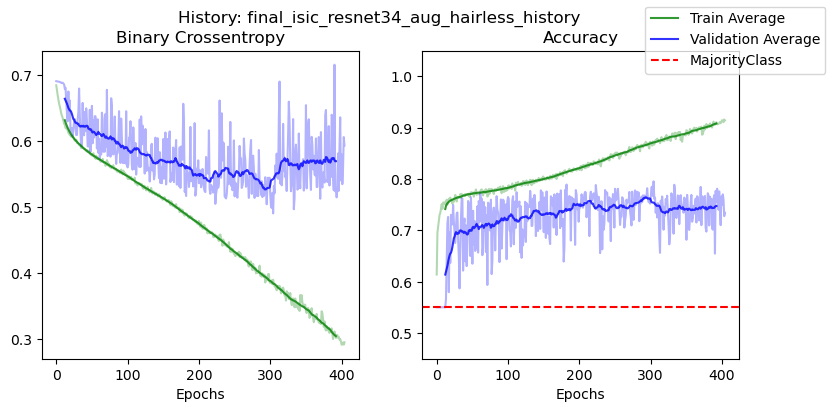

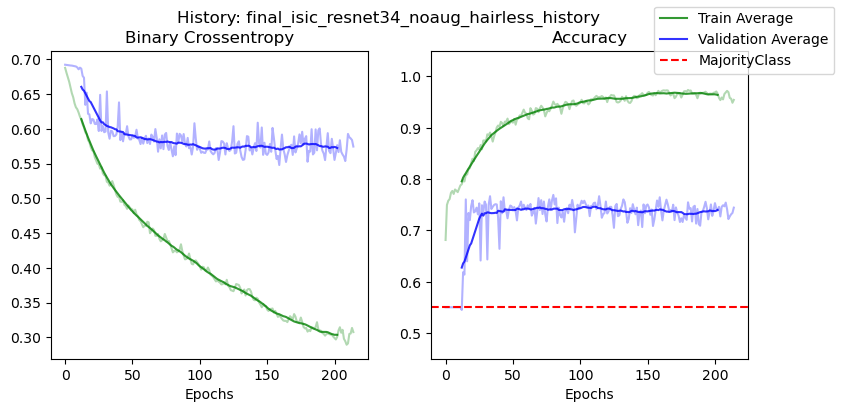

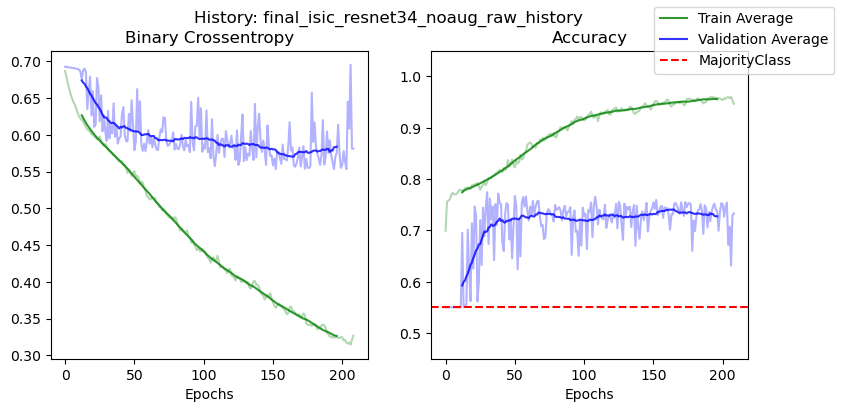

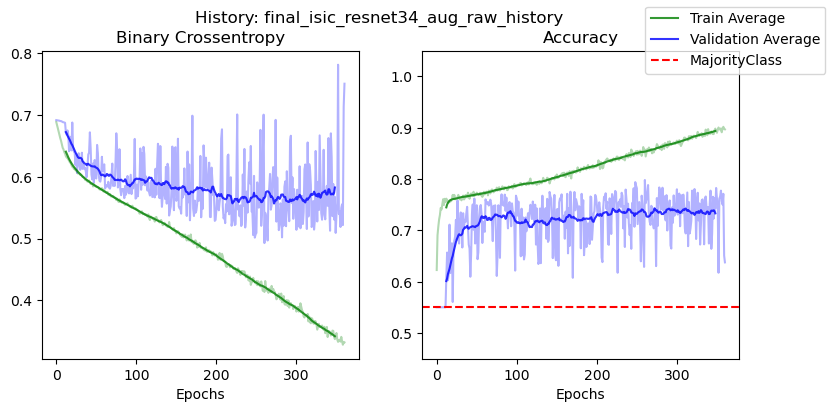

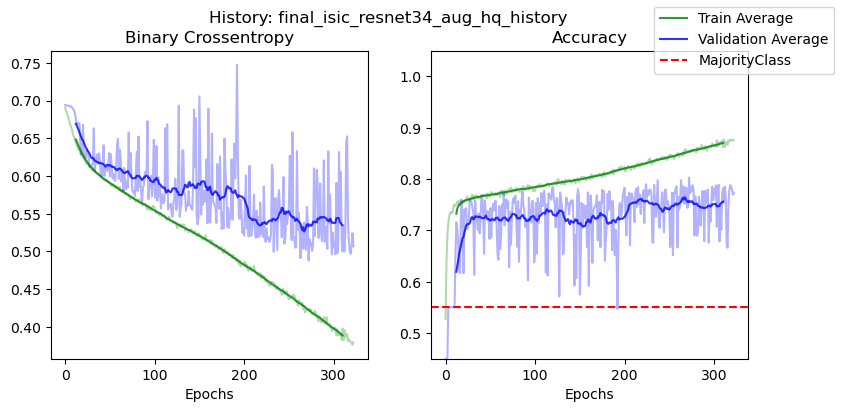

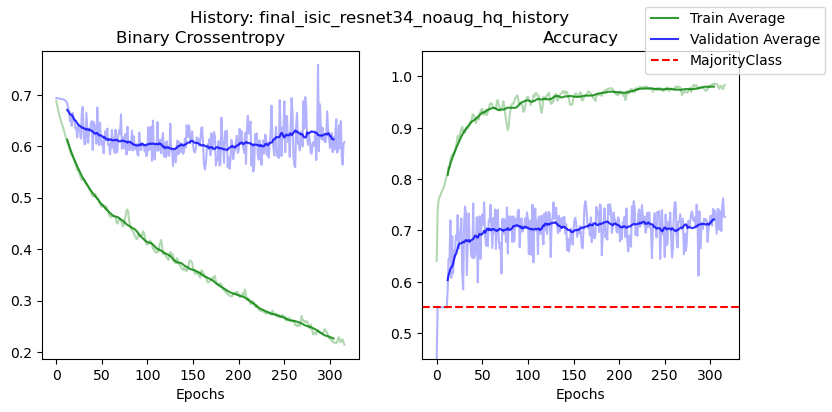

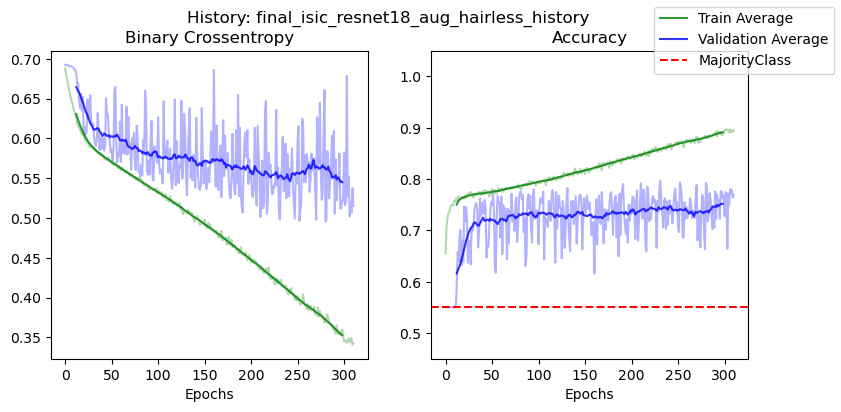

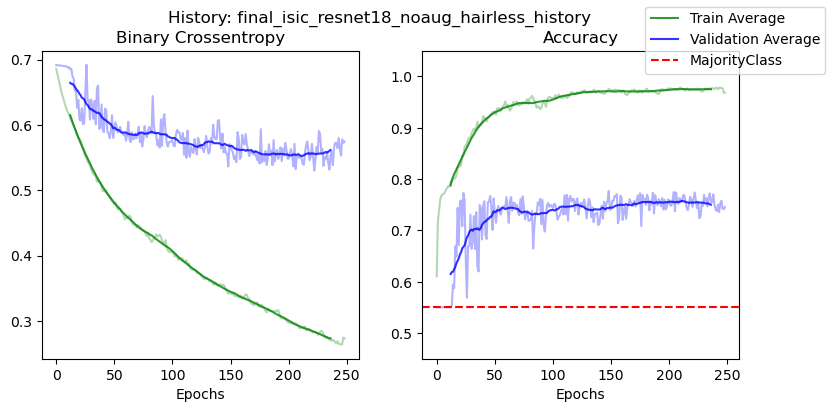

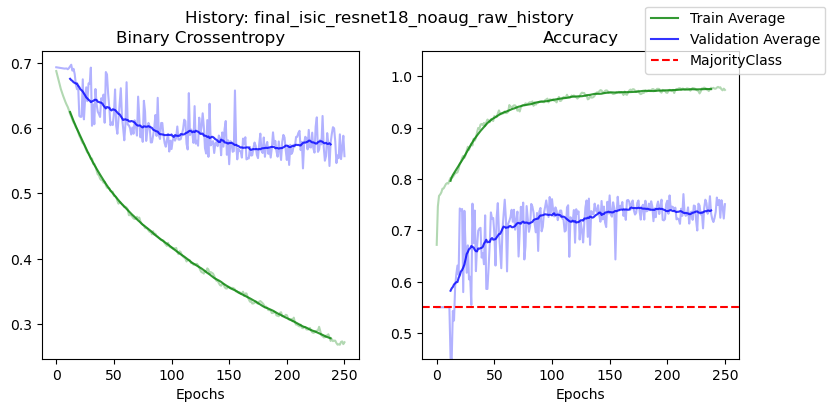

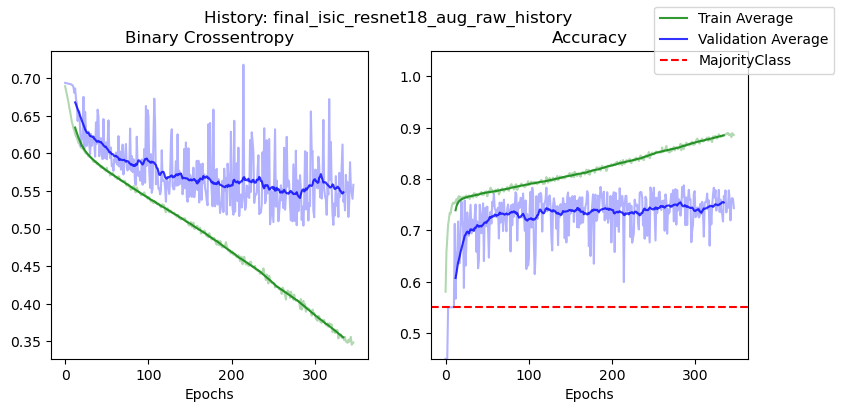

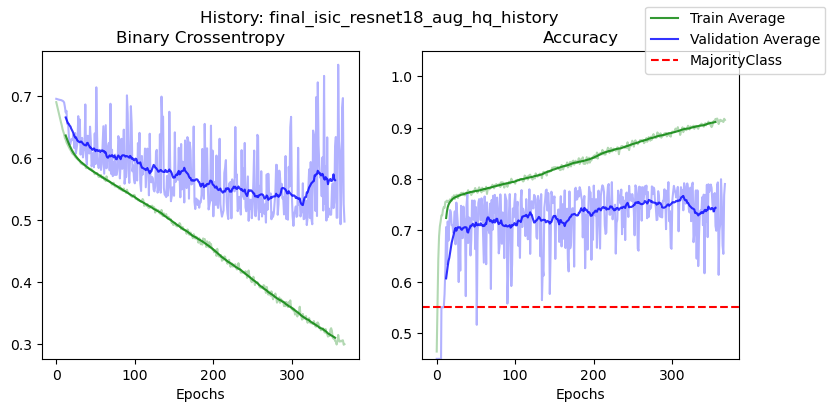

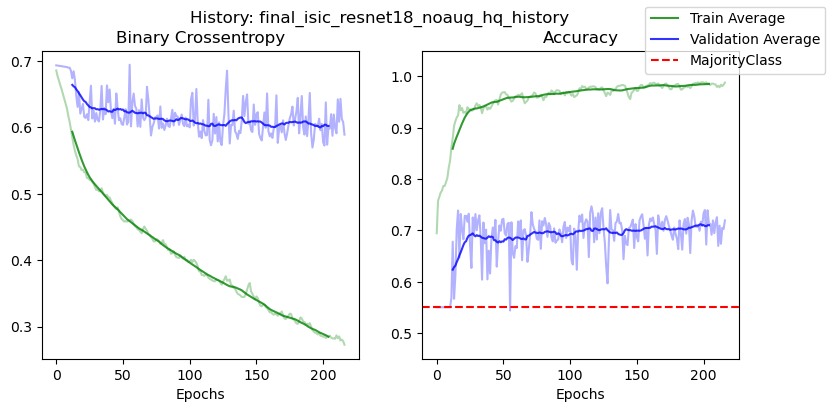

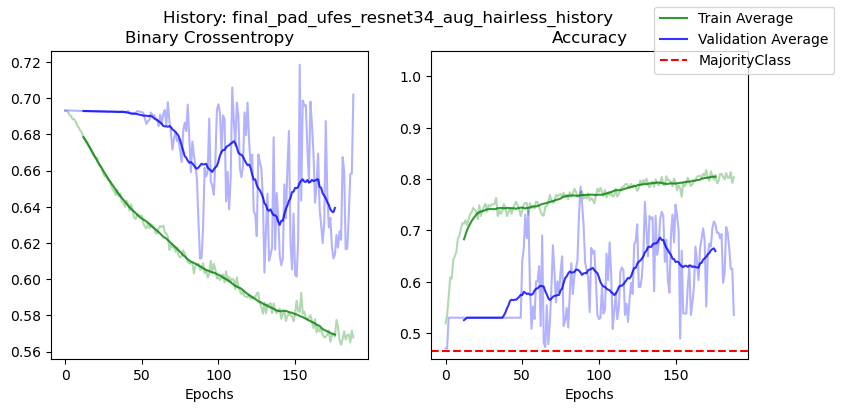

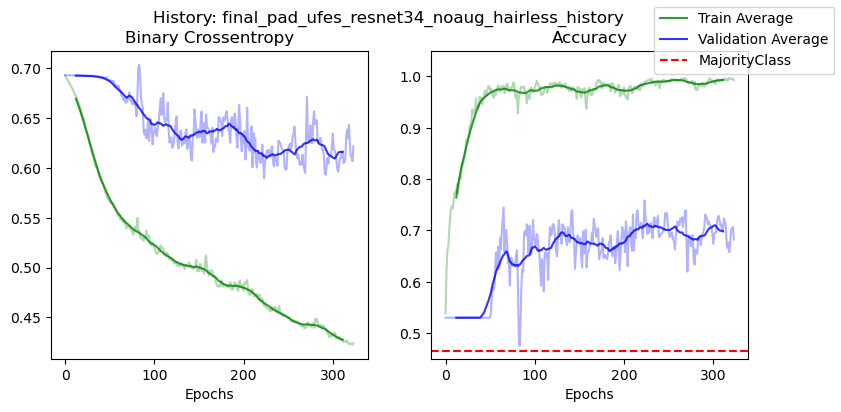

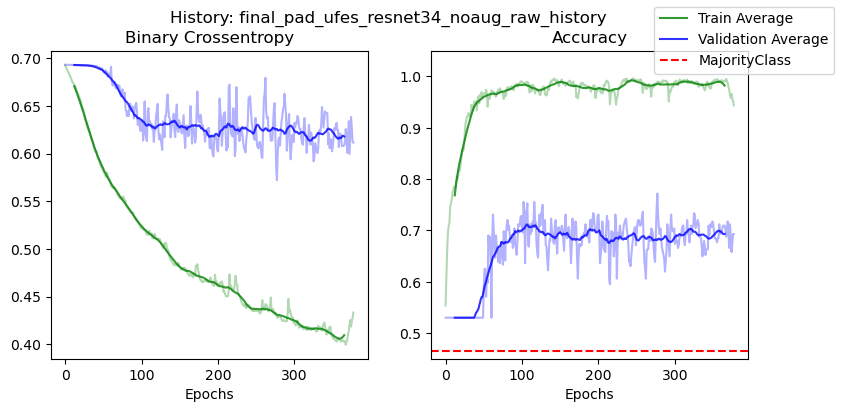

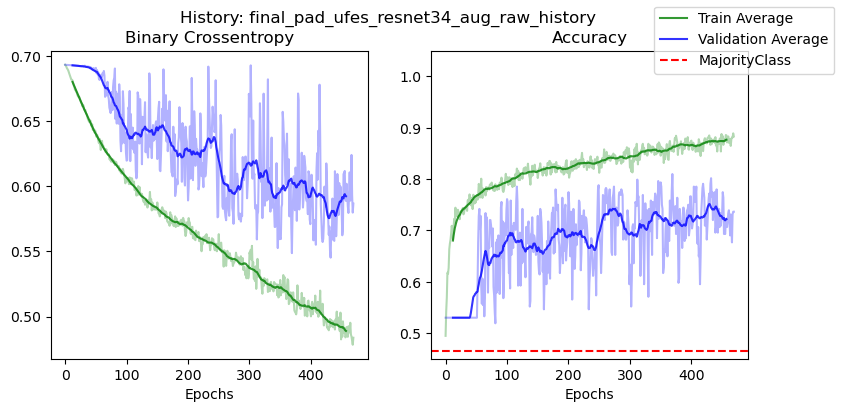

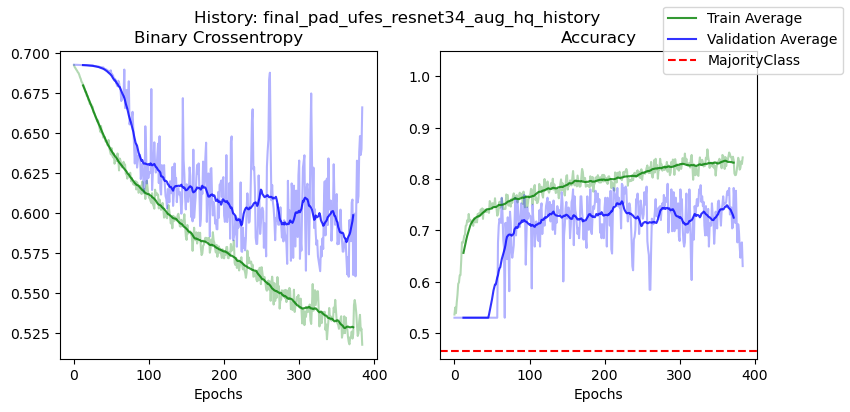

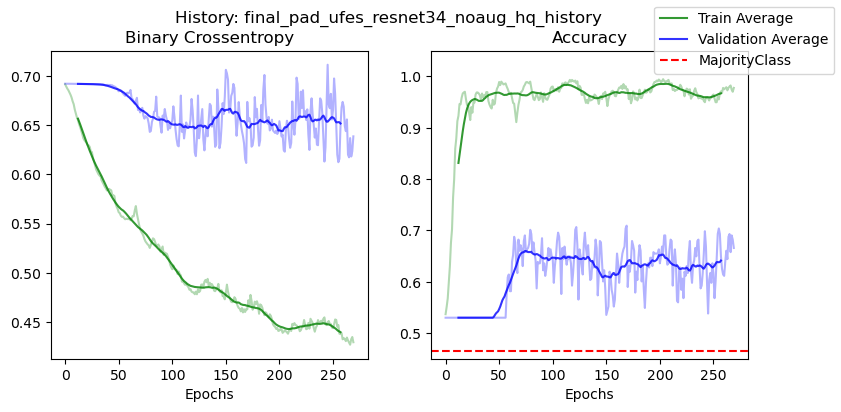

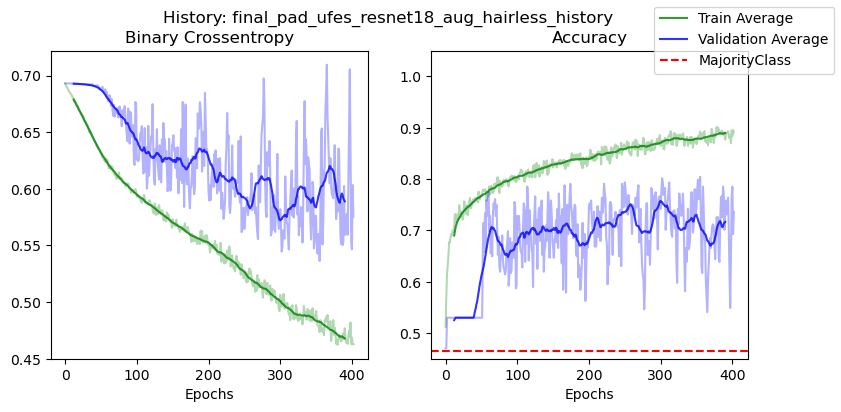

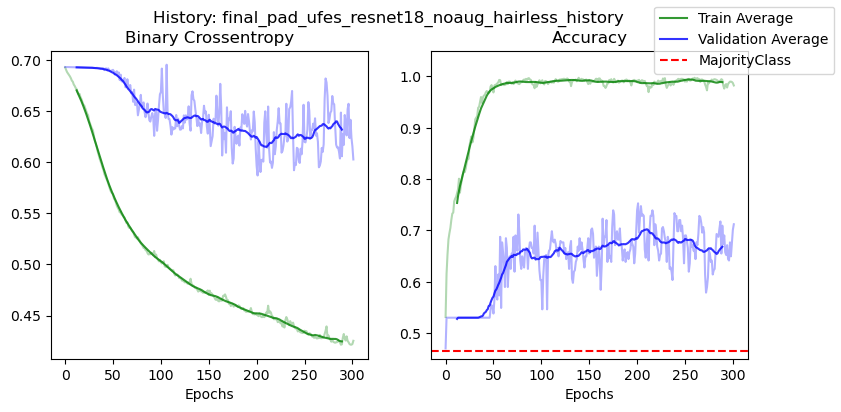

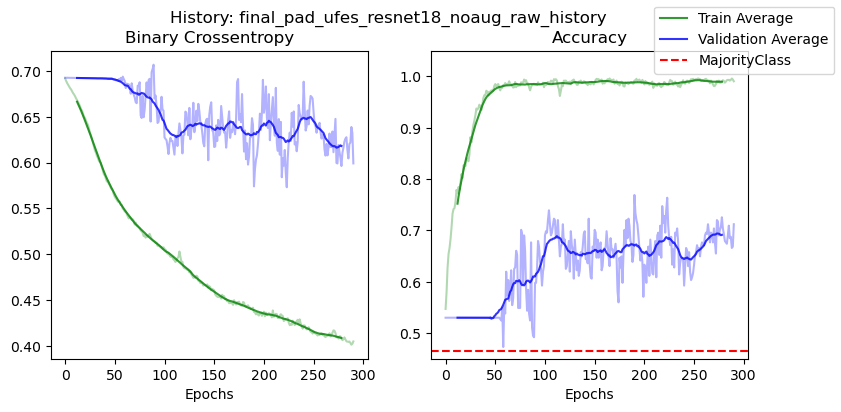

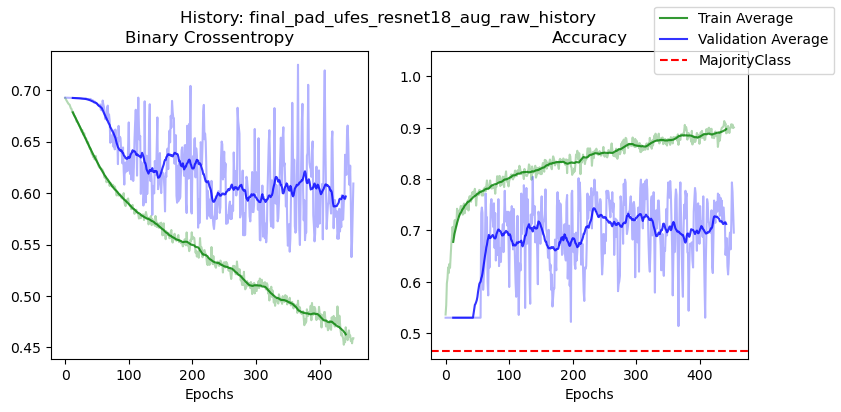

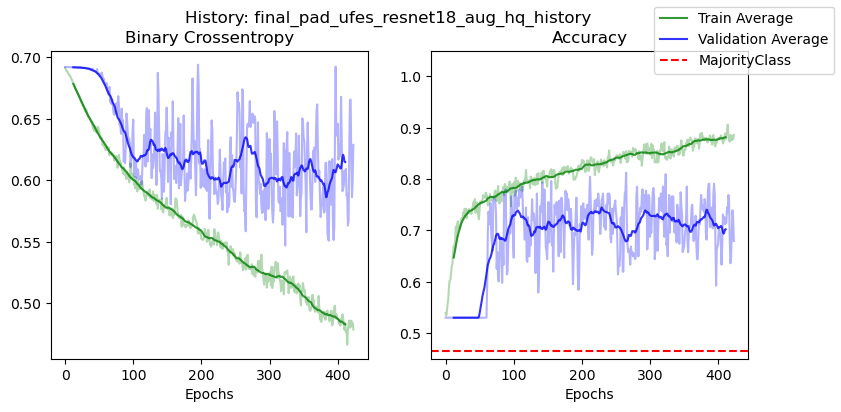

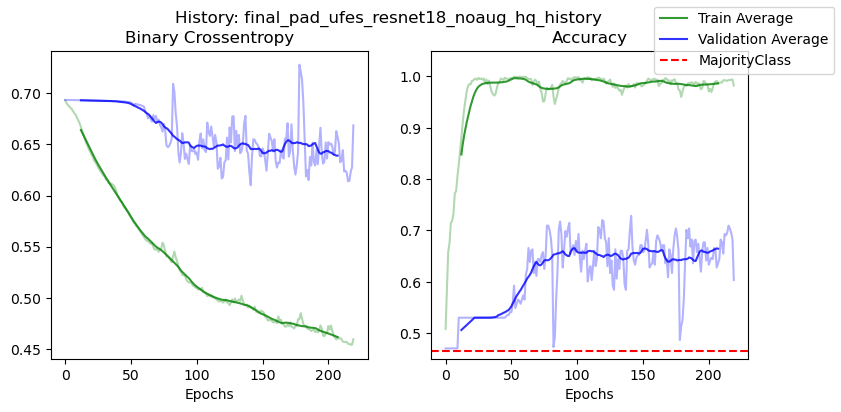

In [13]:
METRICS = ["loss", "acc"]

Names = { # Prettyfied names for titles
    "loss": "Binary Crossentropy",
    "acc": "Accuracy",
    "auc": "ROC-AUC"
}

def moving_average(a, n=25) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

DO_MOVING_AVG = True

for m_name, history in models_fixed.items():
    fig = plt.figure(figsize=(9,4))
    fig.suptitle("History: " + m_name)
    axList = []
    for i, m in enumerate(METRICS):
        axList.append(fig.add_subplot(1,2,i+1))
        try:
            train_m = history[m]
            val_m = history['val_'+m]
            x = range(len(train_m))
            axList[i].set_title(Names[m])
            axList[i].set_xlabel("Epochs")
            if i == 0:
                axList[i].plot(x, train_m, alpha=0.3, color='green')
                axList[i].plot(x, val_m, alpha=0.3, color='blue')
                if DO_MOVING_AVG:
                    axList[i].plot(x[12:-12], moving_average(train_m), label='Train Average', alpha=0.8, color='green')
                    axList[i].plot(x[12:-12], moving_average(val_m), label='Validation Average', alpha=0.8, color='blue')
            else:
                axList[i].plot(x, train_m, alpha=0.3, color='green')
                axList[i].plot(x, val_m, alpha=0.3, color='blue')
                if DO_MOVING_AVG:
                    axList[i].plot(x[12:-12], moving_average(train_m), alpha=0.8, color='green')
                    axList[i].plot(x[12:-12], moving_average(val_m), alpha=0.8, color='blue')
            if m != 'loss':
                if 'isic' in m_name:
                    if 'raw' in m_name:
                        h = isic_raw_ratio
                    else:
                        h = isic_hairless_ratio
                else:
                    if 'raw' in m_name:
                        h = pad_ufes_raw_ratio
                    else:
                        h = pad_ufes_hairless_ratio
                    
                if i==1:
                    axList[i].axhline(h, label='MajorityClass', c='red', ls='--')
                else:
                    axList[i].axhline(h, c='red', ls='--')
                axList[i].set_ylim((0.45, 1.05))
        except KeyError:
            continue
    fig.legend()
    fig.show();

In [7]:
series = dict()
for m_name, history in models_fixed.items():
    series[m_name] = moving_average(history['val_acc'])
    # series[m_name] = history['val_acc']

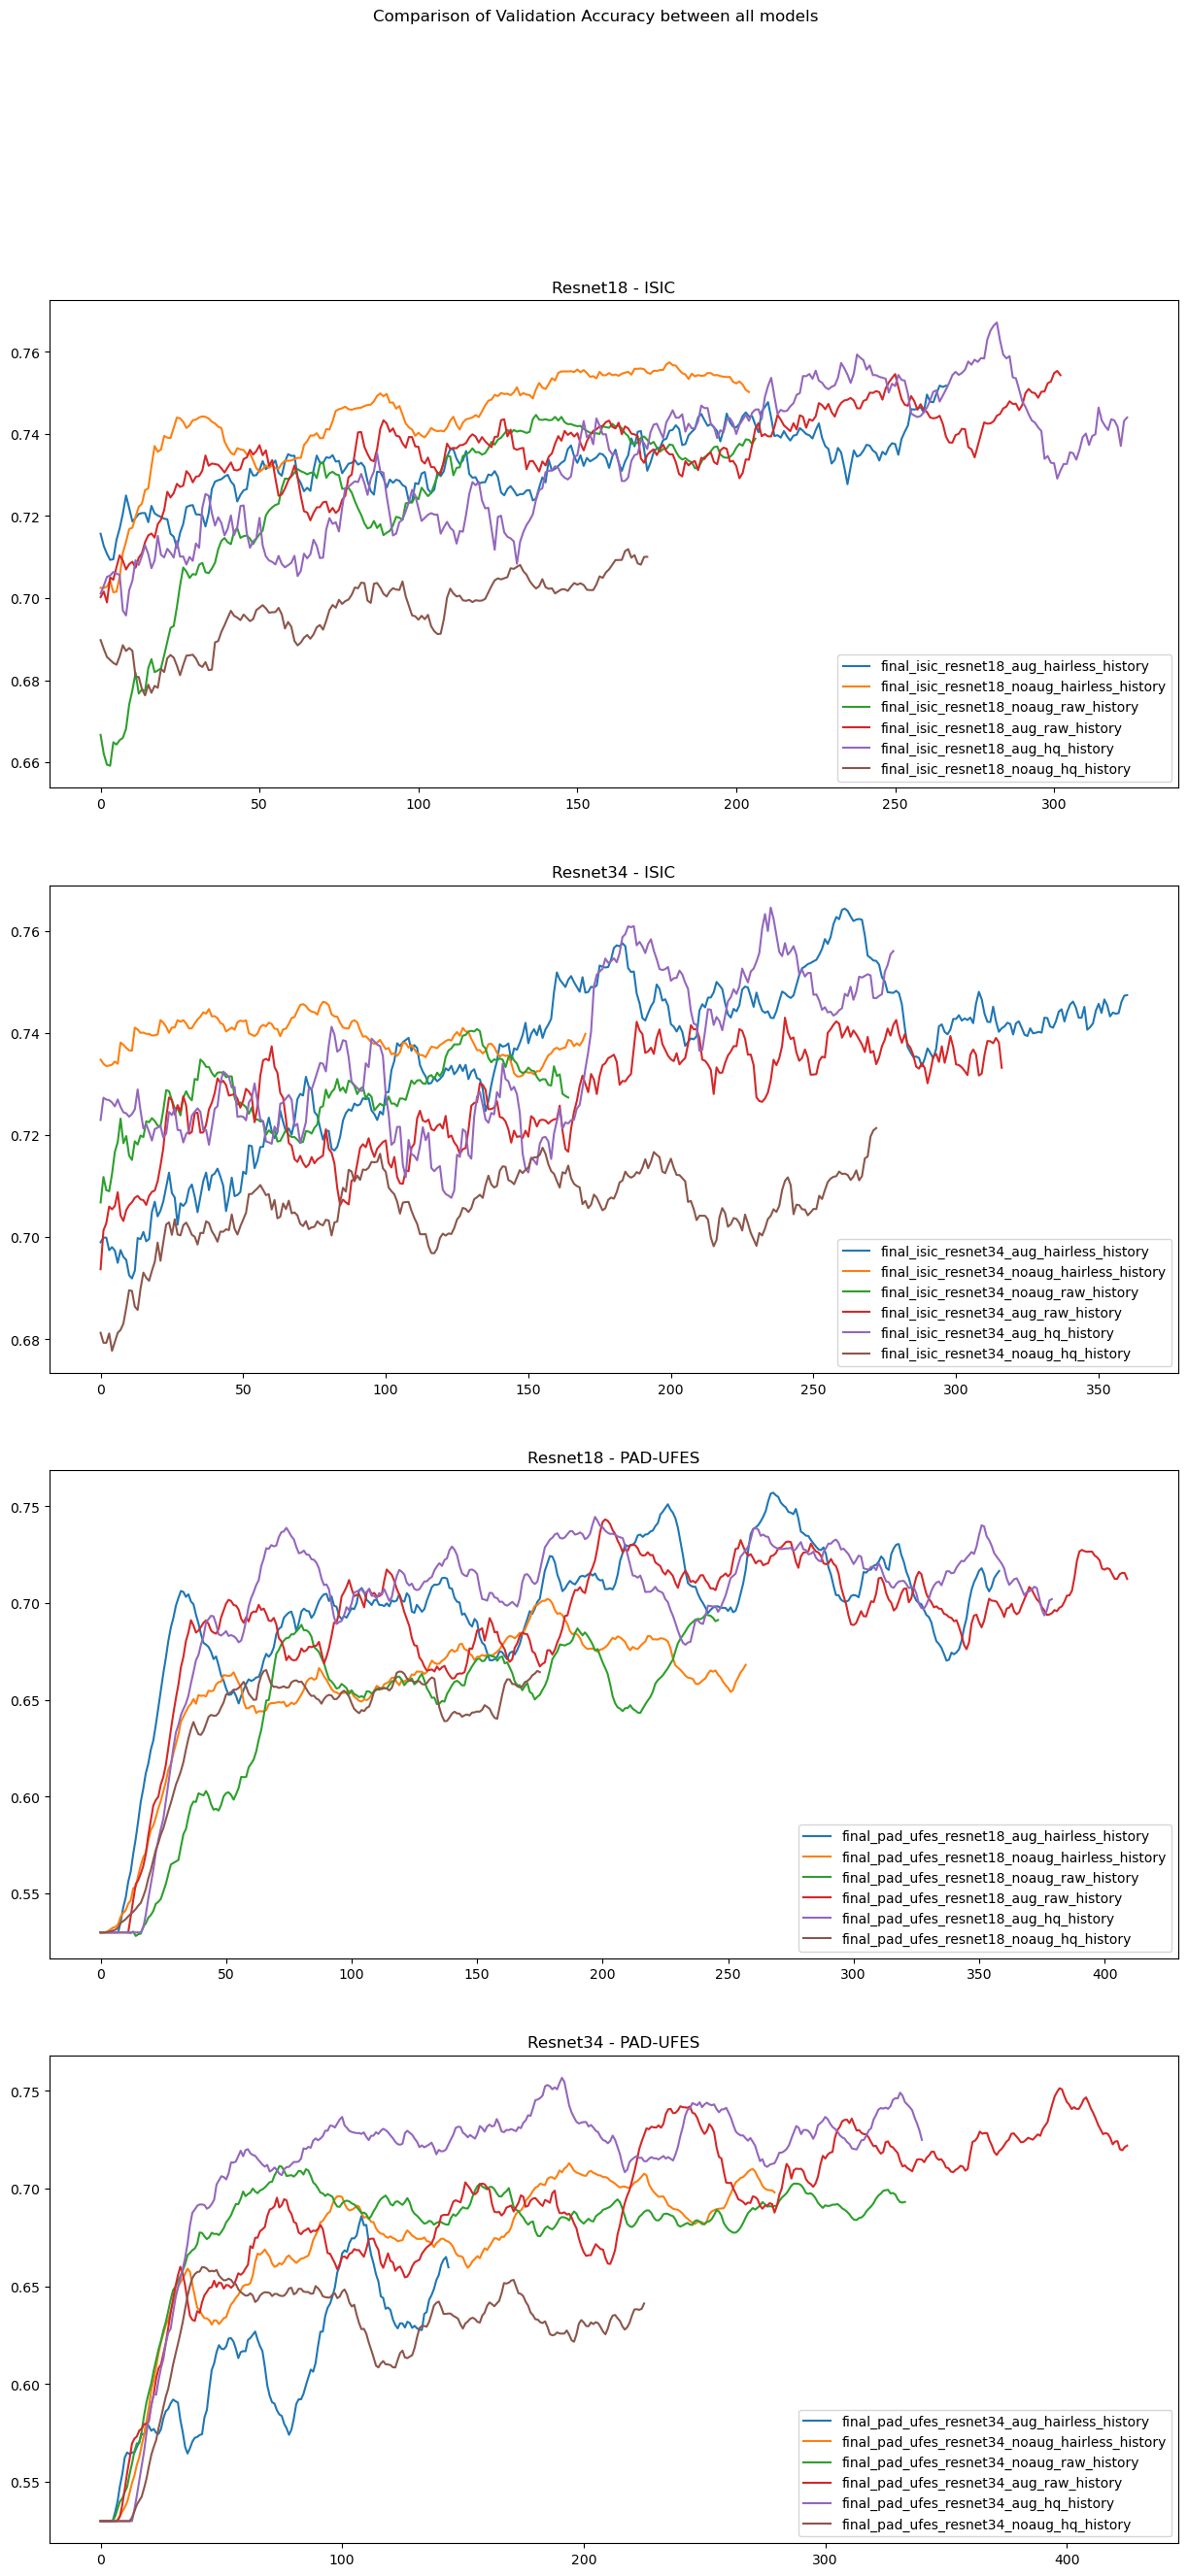

In [8]:
TRASH_FIRST_N = 20

fig = plt.figure(figsize=(15,30))
ax = fig.add_subplot(4,1,1)
ax.set_title("Resnet18 - ISIC")
ax2 = fig.add_subplot(4,1,2)
ax2.set_title("Resnet34 - ISIC")
ax3 = fig.add_subplot(4,1,3)
ax3.set_title("Resnet18 - PAD-UFES")
ax4 = fig.add_subplot(4,1,4)
ax4.set_title("Resnet34 - PAD-UFES")

fig.suptitle("Comparison of Validation Accuracy between all models")
for m_name, history in series.items():
    x = range(len(history[TRASH_FIRST_N:]))
    if 'isic' in m_name:
        if "resnet18" in m_name:
            ax.plot(x, history[TRASH_FIRST_N:], label=m_name)
        else:
            ax2.plot(x, history[TRASH_FIRST_N:], label=m_name)
    else:
        if "resnet18" in m_name:
            ax3.plot(x, history[TRASH_FIRST_N:], label=m_name)
        else:
            ax4.plot(x, history[TRASH_FIRST_N:], label=m_name)


ax.legend()
ax2.legend()
ax3.legend()
ax4.legend()
fig.show();